In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import time
import scipy as sp
import numpy as np
import igraph as ig
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import rcParams as rc

from typing import List, Dict, Tuple

from src.graph_analyzer import NetworkAnalyzer as na
from src.utils.graph_generator import GraphGenerator
from NetworkingWithKuraPy.src.utils.io import IO as io

In [2]:
xmgr_style = {
    # 'text.usetex': False,
    'font.family': 'times new roman',  # Replace with the actual font family used by xmgr
    # 'font.family': 'serif',  # Replace with the actual font family used by xmgr
    'font.size': 16,          # Replace with the actual font size used by xmgr
    'font.style': 'normal',
    'lines.linewidth': 2,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 20,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'grid.color': 'gray',
    'axes.grid': 0,
    'axes.facecolor': 'white',  # Background color of the plot area
    'figure.facecolor': 'white',  # Background color of the entire figure
    'lines.linewidth': 1,
    'lines.markersize': 5.5,
    'legend.frameon': False,
    'xtick.direction': 'in',  # Added tick_params settings for both x and y axes
    'ytick.direction': 'in',
    'xtick.minor.size': 3.0,
    'xtick.major.size': 6.0,
    'ytick.minor.size': 3.0,
    'ytick.major.size': 6.0,
    'xtick.minor.visible': True,
    'xtick.minor.width': 0.8,
    'xtick.major.width': 1.0,
    'ytick.minor.width': 0.8,
    'ytick.major.width': 1.0,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.top': True,
    'ytick.right': True,
    'mathtext.bf': 'times new roman:bold',
    #'mathtext.bfit': 'times new roman:italic:bold',
    'mathtext.cal': 'cursive',
    'mathtext.default': 'it',
    'mathtext.fallback': 'cm',
    'mathtext.fontset': 'cm',
    'mathtext.it': 'times new roman:italic',
    'mathtext.rm': 'times new roman',
    'mathtext.sf': 'times new roman',
    'mathtext.tt': 'monospace'
}

# Apply the custom style
rc.update(xmgr_style)

# Kuramoto model on various graph model and real world networks
## Project for Bioinspired Systems 2024
---
#### 11 of December, 2024, Budapest
#### Kristóf Benedek
email: kristof.benedek@edu.bme.hu

## Introduction

Synchronization phenomena is fascinating and it occurs in our everyday life, more over it also governs numerous processes. Just think about opinion dynamics, traffic, applause, fireflies' flickering and neurons.

For different systems and dynamics several models are implemented and used. One such well-known model is the Kuramoto model. It comes in many flavours, generally building on two major variants, namely the first and second order Kuramoto model.



**The first-order Kuramoto model** describes the dynamics of $ N $ coupled oscillators. The equation is:

$$
\frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Variables**:
  - $ \theta_i $: The phase of the $ i $-th oscillator.
  - $ \omega_i $: The natural frequency of the $ i $-th oscillator, drawn from a distribution (often Gaussian or uniform).
  - $ K $: Coupling strength that determines how strongly the oscillators interact.
  - $ N $: Total number of oscillators.

#### **Interpretation**:
1. **Natural Frequency** ($ \omega_i $):
   - Each oscillator has a natural tendency to oscillate at its own frequency.
2. **Coupling Term** ($ \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i) $):
   - Oscillators influence each other through this term. If $ K > 0 $, they tend to synchronize by pulling their phases closer.
3. **Behavior**:
   - At low coupling ($ K $), oscillators remain desynchronized.
   - At high coupling, synchronization emerges, where oscillators align their phases or move coherently.
   - A phase transition from incoherence to partial or full synchronization occurs as $ K $ increases.

This first-order equation is widely used to study synchronization in coupled systems as brain, Jospehson junctions, opinion dynamics.


**The second-order Kuramoto model** includes an inertia term, which adds dynamics for systems where momentum or damping effects are significant. The equation is:

$$
m \frac{d^2 \theta_i}{dt^2} + \gamma \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Additional Variables**:
  - $ m $: Inertia or mass of the oscillators.
  - $ \gamma $: Damping coefficient.

#### **Interpretation**:
1. **Inertia Term** ($ m \frac{d^2\theta_i}{dt^2} $):
   - Introduces oscillatory inertia, relevant in systems where the oscillators resist changes to their velocities.
   - Examples: Power grids, mechanical oscillators, or systems with delayed adjustments.
2. **Damping Term** ($ \gamma \frac{d\theta_i}{dt} $):
   - Accounts for dissipation of energy, reducing the oscillators' velocities over time.
3. **Behavior**:
   - For low damping ($ \gamma $), the system can exhibit oscillatory or chaotic dynamics.
   - At high damping, the model simplifies to the first-order Kuramoto model.
   - The system can show richer synchronization behavior, such as frequency clustering or hysteresis effects.

---

### **Key Differences Between First and Second-Order Models**

| Aspect                  | First-Order Model                              | Second-Order Model                              |
|-------------------------|-----------------------------------------------|------------------------------------------------|
| Dynamics                | Simplified, phase-only evolution.             | Includes inertia and velocity effects.         |
| Applicability           | Systems where inertia is negligible.          | Systems with momentum or delayed adjustments.  |
| Synchronization Behavior| Phase transitions from incoherence to sync.    | Richer dynamics: oscillations, clustering.     |
| Complexity              | Easier to analyze and simulate.               | More complex but realistic in some contexts.   |

Both models have been widely used to study synchronization in various systems, from neuroscience to power grid stability and social dynamics.

## Aims

In this work I will attempt to investigate how synschronization dynamics is affected by the structure of the underlying system. This will mean in practice, that we will generate some synthetic graphs via some well-known methods such as:
- Erdős-Rényi
- Small-World
- Barabási-Albert (preferential attachement)
- Stohastic Block Method (SBM)

We will compare the synchronization dynamics with a few real world examples, such as:
- a road network of a city
- some brain netwrok
where the application of the Kuramoto model can be motivated.

In the first part we will compute some properties of the graphs, such as:
- centrality measures (mainly betweeness)
- degree distributions
- community structure (one method only: infomap) 
- diameter of the graph
- average degree
- clustering coefficient
- number of triangles

In the second part, we will simulate the Kuramoto model on these graphs and observe the synchronization dynamics. We will use the Kuramoto model implemented in the NetworkingWithKuraPy library developed by me and a colleague of mine. This repo is not yet public as it is still under development, for accessing or viewing the code please contact me.

---

## Part I - Analyzing the graphs



In [3]:
gen = GraphGenerator

graphs_collector = {}

generate = 0
if generate:
    # Erdős-Rényi graph
    erdos_renyi_graph = gen.generate_erdos_renyi(n=1000, m=1700)
    graphs_collector["erdos_renyi"] = erdos_renyi_graph
    print("Erdős-Rényi graph generated with", len(erdos_renyi_graph.vs), "vertices and", len(erdos_renyi_graph.es), "edges.")

    # Small-World graph
    small_world_graph = gen.generate_small_world(n=1000, k=4, p=0.2)
    graphs_collector["small_world"] = small_world_graph
    print("Small-World graph generated with", len(small_world_graph.vs), "vertices and", len(small_world_graph.es), "edges.")

    # Barabási-Albert graph
    barabasi_albert_graph = gen.generate_barabasi_albert(n=1000, m=2)
    graphs_collector["barabasi_albert"] = barabasi_albert_graph
    print("Barabási-Albert graph generated with", len(barabasi_albert_graph.vs), "vertices and", len(barabasi_albert_graph.es), "edges.")

    # Stochastic Block Model graph
    p1 = [[0.1, 0.01, 0.01, 0.01, 0.01], 
    [0.1, 0.01, 0.01, 0.01, 0.01],
    [0.1, 0.01, 0.01, 0.01, 0.01],
    [0.1, 0.01, 0.01, 0.01, 0.01],
    [0.1, 0.01, 0.01, 0.01, 0.01]]

    p2 = np.random.uniform(0.0001, 0.0065,(6,6))
    p2 = (p2+p2.T)/2
    np.fill_diagonal(p2, np.random.uniform(0.005, 0.015, 6))
    sbm_graph = gen.generate_stochastic_block_model(n=1000,sizes=[50, 150, 200, 225, 125, 250], 
                                            p_matrix=p2)
    graphs_collector["sbm"] = sbm_graph
    print("Stochastic Block Model graph generated with", len(sbm_graph.vs), "vertices and", len(sbm_graph.es), "edges.")

    brain_graph = ig.Graph(edges=np.loadtxt("other_nets/brain/bn-mouse-kasthuri_graph_v4/bn-mouse-kasthuri_graph_v4.edges", dtype =int), directed = False)
    graphs_collector["mouse_brain"] = brain_graph
    print(f"Mouse Brain graph generated with {len(brain_graph.vs)} veritces and {len(brain_graph.es)} edges")

    power_graph = ig.Graph(edges=np.loadtxt("other_nets/power/power-US-Grid/power-US-Grid.mtx", dtype =int, comments="%"), directed = False)
    graphs_collector["power_network"] = power_graph
    print(f"Power Network graph generated with {len(power_graph.vs)} veritces and {len(power_graph.es)} edges")
else:
    for name in ["erdos_renyi", "small_world", "barabasi_albert", "sbm", "mouse_brain", "power_network"]:
        graph = ig.Graph.Read_Edgelist(f"graphs/{name}.edgelist", directed=False)
        graphs_collector[name] = graph
        print(f"{name} graph loaded with {len(graph.vs)} veritces and {len(graph.es)} edges")

erdos_renyi graph loaded with 1000 veritces and 1700 edges
small_world graph loaded with 1000 veritces and 2000 edges
barabasi_albert graph loaded with 1000 veritces and 1997 edges
sbm graph loaded with 1000 veritces and 2055 edges
mouse_brain graph loaded with 1029 veritces and 1700 edges
power_network graph loaded with 4942 veritces and 6594 edges


In [4]:
graph_result_container = {}
save_graphs = False
save_input_for_kp = False
plot_graphs = False
for name , graph in graphs_collector.items():
    print(name)
    result = na.get_basic_properties(graph)
    graph_result_container[name] = result
    
    if save_graphs:
        savedir = f"graphs/{name}/"
        os.makedirs(savedir, exist_ok=True) 
        graph.write_edgelist(f"graphs/{name}.edgelist")

    # Find the connected components
    components = graph.clusters()

    # Extract the giant component (largest connected component)
    giant_component = components.giant()
    communities = na.detect_communities(giant_component, 'infomap')
    
    if save_input_for_kp:
        giant_component.write_edgelist(savedir+f"edges.dat")        
        np.savetxt(savedir+f"communities.dat", communities)
    
    print("Giant components stat:")
    print(f"Edges: {giant_component.ecount()}, vertices: {giant_component.vcount()}")
    print("")
    if plot_graphs:
        na.plot_graph(graph, savename=f'graphs/{name}.png', layout='rt_circular')
    

erdos_renyi
Giant components stat:
Edges: 1699, vertices: 968

small_world
Giant components stat:
Edges: 2000, vertices: 999

barabasi_albert
Giant components stat:
Edges: 1997, vertices: 1000

sbm
Giant components stat:
Edges: 2053, vertices: 968

mouse_brain
Giant components stat:
Edges: 1677, vertices: 987

power_network
Giant components stat:
Edges: 6594, vertices: 4941



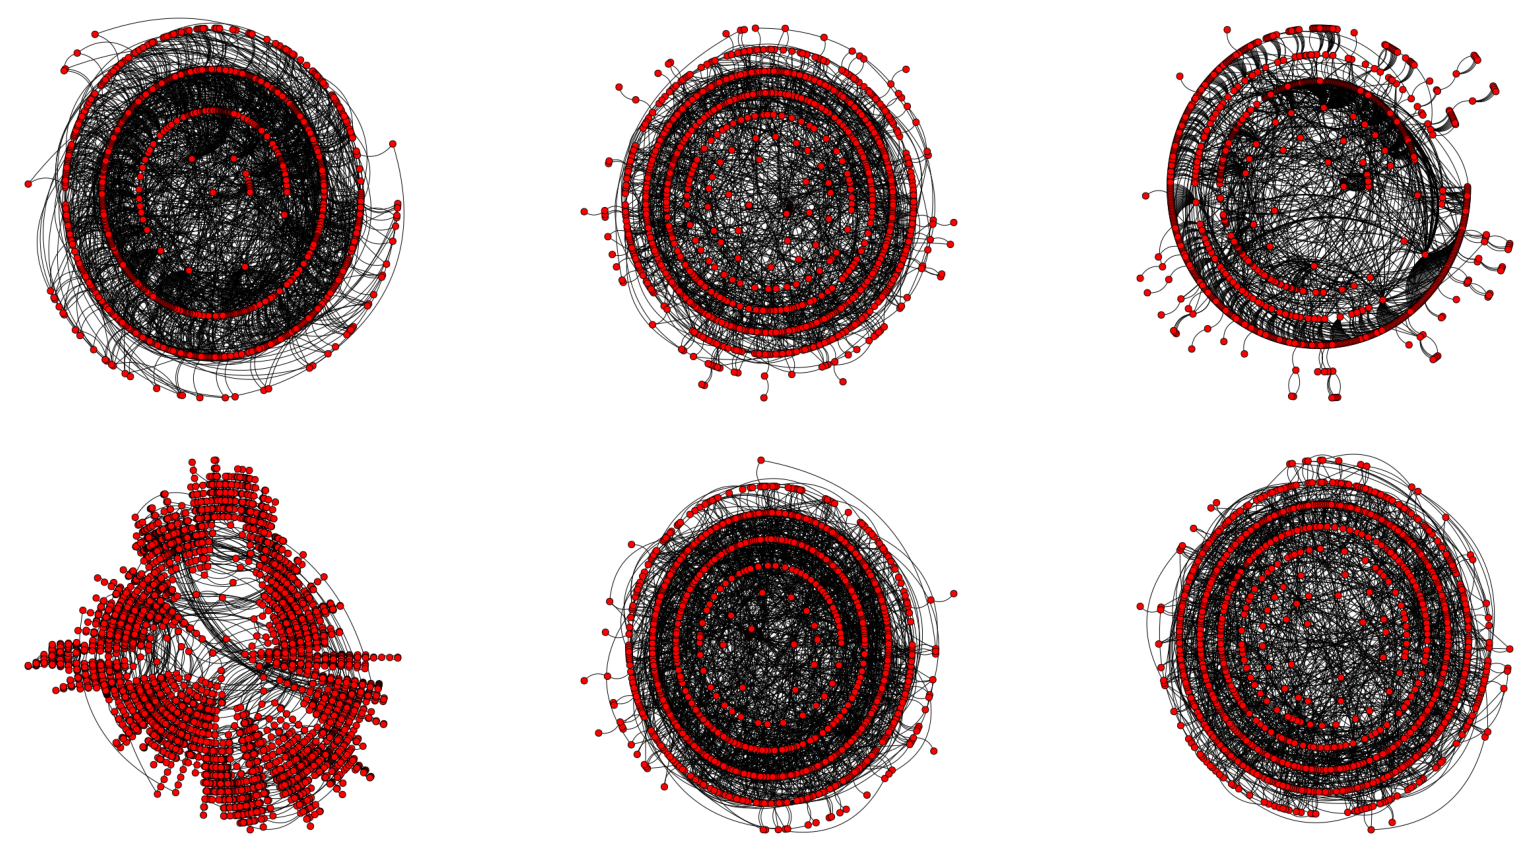

In [5]:
na.plot_images_from_folder("graphs", subplot_ratio=(2, 3), savename="all_graphs.png")

In [ ]:
all_properties = ['edge_nr', 'vertices_nr', 'avg_degree', 
              'planarity', 'connectedness', 
              'self_loops', 'density', 
              'degree_centrality', 
              'betweenness_centrality', 
              'closeness_centrality', 
              'eigenvector_centrality', 
              'local_clustering_coeffs', 
              'clustering_coeff', 'nr_of_trinagles', 
              'communities_infomap']

properties = ['degree_centrality', 'betweenness_centrality', 
              'closeness_centrality', 'eigenvector_centrality', 
              'local_clustering_coeffs']

bins = 50
for name , graph in graphs_collector.items():
    for property in properties:
        root_dir = f"tmp/{property}/nofit/"
        # root_dir = f"imgs/{name}/nofit/"
        
        print(name, property)
        savepath = root_dir + f"logy/"
        os.makedirs(savepath, exist_ok = True)
        savename = savepath+f"{name}_{property}.png"
        na.histogram(graph_result_container[name][property], 
                     distfit_enabled=0, bins = bins, savename=savename,
                     data_label=property, show=0, logy=1, logx=0)
        
        savepath = root_dir + f"logxy/"
        os.makedirs(savepath, exist_ok = True)
        savename = savepath+f"{name}_{property}.png"
        na.histogram(graph_result_container[name][property], 
                     distfit_enabled=0, bins = bins, savename=savename,
                     data_label=property, show=0, logy=1, logx=1)
        
        savepath = root_dir + f"normal/"
        os.makedirs(savepath, exist_ok = True)
        savename = savepath+f"{name}_{property}.png"
        na.histogram(graph_result_container[name][property], 
                     distfit_enabled=0, bins = bins, savename=savename,
                     data_label=property, show=0, logy=0, logx=0)


# na.histogram(graphs_collector['erdos_renyi'].betweenness(), distfit_enabled=1, bins = 50)

erdos_renyi degree_centrality
erdos_renyi betweenness_centrality
erdos_renyi closeness_centrality
erdos_renyi eigenvector_centrality
erdos_renyi local_clustering_coeffs
small_world degree_centrality
small_world betweenness_centrality
small_world closeness_centrality
small_world eigenvector_centrality
small_world local_clustering_coeffs
barabasi_albert degree_centrality
barabasi_albert betweenness_centrality
barabasi_albert closeness_centrality
barabasi_albert eigenvector_centrality
barabasi_albert local_clustering_coeffs
sbm degree_centrality
sbm betweenness_centrality
sbm closeness_centrality
sbm eigenvector_centrality
sbm local_clustering_coeffs
mouse_brain degree_centrality
mouse_brain betweenness_centrality
mouse_brain closeness_centrality
mouse_brain eigenvector_centrality
mouse_brain local_clustering_coeffs
power_network degree_centrality
power_network betweenness_centrality
power_network closeness_centrality
power_network eigenvector_centrality
power_network local_clustering_coe

In [14]:
all_properties = ['edge_nr', 'vertices_nr', 'avg_degree', 
              'planarity', 'connectedness', 
              'self_loops', 'density', 
              'degree_centrality', 
              'betweenness_centrality', 
              'closeness_centrality', 
              'eigenvector_centrality', 
              'local_clustering_coeffs', 
              'clustering_coeff', 'nr_of_trinagles', 
              'communities_infomap']

properties = ['degree_centrality', 'betweenness_centrality', 
              'closeness_centrality', 'eigenvector_centrality', 
              'local_clustering_coeffs']

bins = 50

for name , graph in graphs_collector.items():
    for property in properties:
        print(name, property)
        if name == "power_network" and property == "eigenvector_centrality":
            continue
        else:
            root_dir = f"tmp/{property}/fit/"
            # root_dir = f"imgs/{name}/fit/"
            savepath = root_dir+f"logy/"
            os.makedirs(savepath, exist_ok = True)
            savename = savepath+f"{name}_{property}.png"
            na.histogram(graph_result_container[name][property], 
                        distfit_enabled=1, bins = bins, savename=savename,
                        data_label=property, show=0, logy=1, logx=0)
            
            savepath =  root_dir+f"logxy/"
            os.makedirs(savepath, exist_ok = True)
            savename = savepath+f"{name}_{property}.png"
            na.histogram(graph_result_container[name][property], 
                        distfit_enabled=1, bins = bins, savename=savename,
                        data_label=property, show=0, logy=1, logx=1)
            
            savepath =  root_dir+f"normal/"
            os.makedirs(savepath, exist_ok = True)
            savename = savepath+f"{name}_{property}.png"
            na.histogram(graph_result_container[name][property], 
                        distfit_enabled=1, bins = bins, savename=savename,
                        data_label=property, show=0, logy=0, logx=0)

erdos_renyi degree_centrality
erdos_renyi betweenness_centrality
erdos_renyi closeness_centrality
erdos_renyi eigenvector_centrality
erdos_renyi local_clustering_coeffs
small_world degree_centrality
small_world betweenness_centrality
small_world closeness_centrality
small_world eigenvector_centrality
small_world local_clustering_coeffs
barabasi_albert degree_centrality
barabasi_albert betweenness_centrality
barabasi_albert closeness_centrality
barabasi_albert eigenvector_centrality
barabasi_albert local_clustering_coeffs
sbm degree_centrality
sbm betweenness_centrality
sbm closeness_centrality
sbm eigenvector_centrality
sbm local_clustering_coeffs
mouse_brain degree_centrality
mouse_brain betweenness_centrality
mouse_brain closeness_centrality
mouse_brain eigenvector_centrality
mouse_brain local_clustering_coeffs
power_network degree_centrality
power_network betweenness_centrality
power_network closeness_centrality
power_network eigenvector_centrality
power_network local_clustering_coe

In [ ]:
for name , graph in graphs_collector.items():
    na.plot_adjacency_matrix(graph, 
                         label = name, 
                         no_ticks=1,
                         block = 1,
                         mem = np.array(graph_result_container[name]['communities_infomap']),
                         savepath = f"imgs/{name}/")

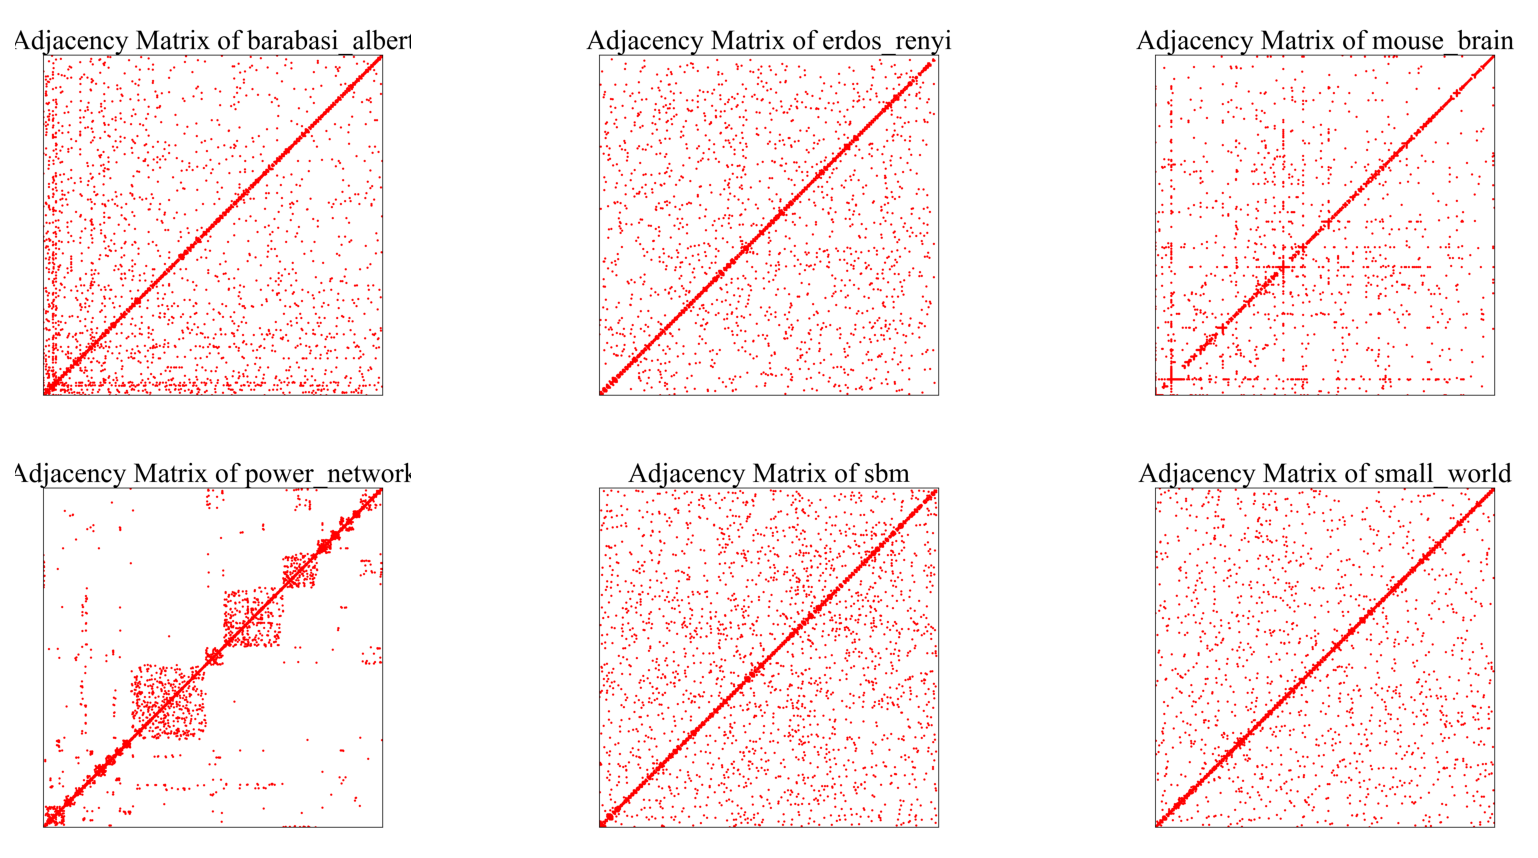

In [8]:
na.plot_images_from_folder("tmp_adj", subplot_ratio=(2, 3), 
                           savename="all_graphs_adj.png",
                           add_title=0)

In [ ]:
properties = ['edge_nr', 'vertices_nr', 'avg_degree', 
              'density', 'clustering_coeff', 'nr_of_trinagles', 
              'communities_infomap']

for property in properties:
    plt.figure(figsize=(10, 8), dpi=150)
    savepath = "imgs/all_graph_plots/"
    os.makedirs(savepath, exist_ok = True)
    savename = savepath+f"all_graph_{property}_comparison.png"
    # Iterate over collected graphs and their results
    for i, (name, graph) in enumerate(graphs_collector.items()):
        # root_dir = f"tmp/{property}/nofit/"  # Uncomment and use if needed for saving
        root_dir = f"imgs/{name}/"  # Example directory
        
        if property == "communities_infomap":
          plt.scatter(i, len(np.unique(graph_result_container[name][property])), 
                      c = 'r', s = 60, ec = 'k')
          
        else:
          # Plot scatter for the current property
          plt.scatter(i, graph_result_container[name][property],
                      c = 'r', s = 60, ec = 'k')
    
    # Set x-axis labels to graph names
    plt.xticks(ticks=range(len(graphs_collector)), labels=list(graphs_collector.keys()), rotation=45)
    
    # Add labels, legend, and layout
    plt.xlabel("Graphs")
    plt.ylabel(property.replace('_', ' ').capitalize())
    plt.title(f"{property.replace('_', ' ').capitalize()} Comparison Across Graphs")
    plt.legend(loc='best')
    plt.tight_layout()
    # plt.savefig(savename, dpi = 300)
    plt.show()

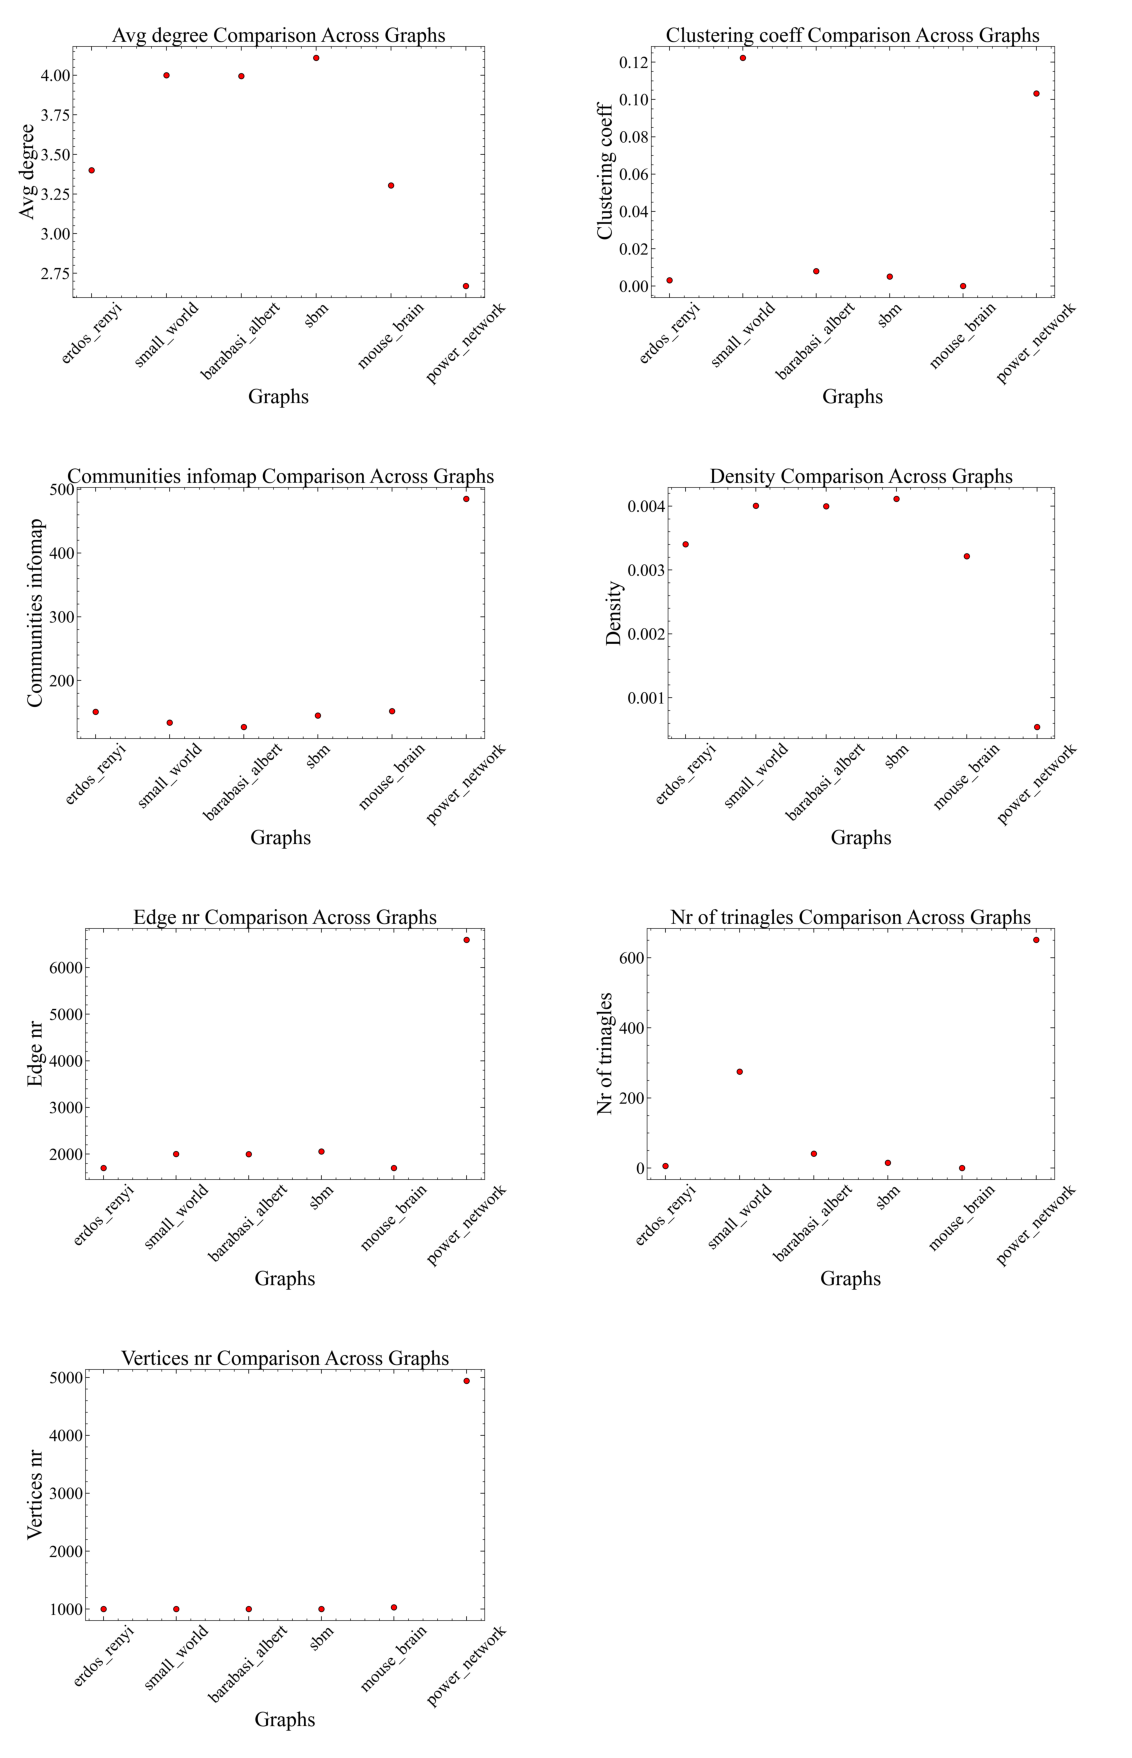

In [129]:
na.plot_images_from_folder("imgs/all_graph_plots/comparison/", subplot_ratio=(4, 2), 
                           savename="all_graphs_comparison.png",
                           add_title=0)

## Part II

In this part I will present some of the results related to the dynamics of the different graphs.

The results shown are averages of 25 runs for each network with the same parametrization. 
- The graphs are all unweighted (edge weights of 1 for each edge) and undirected. 
- Self frequencies were generated from a normal distribution with variance of $1$ and mean of $0$. 
- Initial phases were chosen from a uniform distribution from $[0,2\pi]$
- Damping coefficient is $0.1$
- Global coupling coefficient was set to $5.0$ (after experimentation to achieve synchronization), with the exception of the power network where it was set to $20.$
- $1000$ iteration time was used with timestep of $0.1$
- Adaptive RK4 was used as integrator

In [6]:
def get_avg_std(array, axis: int = 0):
    avg = np.mean(array, axis = axis)
    std = np.std(array, axis = axis)
    
    return avg, std

In [42]:
def plot_metrics(t, all_graph_metrics, 
                 all_graph_styles, 
                 log_scale: List[bool] = [True, True],
                 aspect_ratio: Tuple[float, float] = (22.5, 8.5),  # (width, height)
                 savename: str = None):
    """
    Plots three subplots next to each other for given metrics.

    Parameters:
    -----------
    t : array-like
        Time array.
    all_graph_metrics : list of list of tuples
        Each tuple contains:
        - avg_values: array-like, average values to plot.
        - std_values: array-like, standard deviation values to plot.
        - ylabel: str, label for the y-axis.
        - quantity_label: str, label for the quantity in the legend.
    all_graph_styles : list of list of dict
        Each dict specifies the styles for avg and std lines:
        - 'avg_line': dict of style options for the average line.
        - 'std_line': dict of style options for the standard deviation line.
    log_scale : list of bool, optional. Sets the scales to log if true. 1st element for x, second for y axis
    aspect_ratio : tuple of float, optional. Sets the aspect ratio of the figure. (width, height)
    savename : str, optional
    """
    fig, axes = plt.subplots(1, len(all_graph_metrics[0]), figsize=aspect_ratio)  # 1 row, len(metrics) columns

    for i, single_graph_metrics in enumerate(all_graph_metrics):
        for ax, (avg_values, std_values, ylabel, label) in zip(axes, single_graph_metrics):
            # Plot average values
            ax.plot(
                t, avg_values,
                label=label,
                ms = 12.5,
                **all_graph_styles[i]['avg_line']  # Apply average line styles
            )
            # Plot standard deviation values
            ax.plot(
                t, std_values,
                ms = 12.5,
                **all_graph_styles[i]['std_line']  # Apply std line styles
            )
            ax.set_xlim(0, 20)
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(ylabel)
            if log_scale[0]:
                ax.set_xscale('log')
            if log_scale[1]:
                ax.set_yscale('log')
            ax.grid(True, alpha = 0.7, color='gray')
            ax.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    if savename:
        plt.savefig(savename, dpi=300) 
    plt.show()

def plot_metrics_all_graphs(graph_metrics: List, 
                 graph_styles: List[Dict[str, List]],
                 log_scale: List[bool] = [True, True], 
                 aspect_ratio: Tuple[float, float] = (18.5, 5),  # 18.5 inches wide, 5 inches tall
                 marker_size: int = 15,
                 savename: str = None):
    """
    Plots three subplots next to each other for given metrics.

    Parameters:
    -----------
    graph_metrics : list of list of tuples
        Each tuple contains:
        - avg_values: array-like, average values to plot.
        - std_values: array-like, standard deviation values to plot.
        - ylabel: str, label for the y-axis.
        - quantity_label: str, label for the quantity in the legend.
    graph_styles : list of list of dict
        Each dict specifies the styles for avg and std lines:
        - 'avg_line': dict of style options for the average line.
        - 'std_line': dict of style options for the standard deviation line.
    log_scale : list of bool, optional. Sets the scales to log if true. 1st element for x, second for y axis
    aspect_ratio : tuple of float, optional. Sets the aspect ratio of the figure.
    marker_size : int, optional. Sets the size of the markers in the plot.
    savename : str, optional
    """
    fig, axes = plt.subplots(1, len(graph_metrics[0]), figsize=aspect_ratio)  # 1 row, len(metrics) columns

    for i, graph_metric in enumerate(graph_metrics):
        for ax, (t, avg_values, std_values, ylabel, quantity_label, graph_name) in zip(axes, graph_metric):
            # Plot average values
            ax.plot(
                t, avg_values,
                label=graph_name,
                ms = marker_size,
                **graph_styles[i]['avg_line']  # Apply average line styles
            )
            # Plot standard deviation values
            ax.plot(
                t, std_values,
                ms = marker_size,
                **graph_styles[i]['std_line']  # Apply std line styles
            )
            ax.set_xlim(0, 20)
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(ylabel)
            if log_scale[0]:
                ax.set_xscale('log')
            if log_scale[1]:
                ax.set_yscale('log')
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True, shadow=True, ncol=2)
            ax.grid(True, alpha = 0.7, color='gray')
    plt.tight_layout()  # Adjust layout to prevent overlap
    if savename:
        plt.savefig(savename, dpi=300) 
    plt.show()

In [8]:
def get_relative_subdirectories(source_directory):
    """
    Get all relative subdirectory paths from the source directory.

    Parameters:
        source_directory (str): The source directory to search for subdirectories.

    Returns:
        list: A list of relative subdirectory paths.
    """
    subdirectories, graph_names = [], []
    for root, dirs, _ in os.walk(source_directory):
        for dir_name in dirs:
            # Create the relative path
            graph_name = os.path.relpath(os.path.join(root, dir_name), start=source_directory)
            relative_path = os.path.relpath(os.path.join(root, dir_name), start=os.getcwd())
            
            subdirectories.append(relative_path)
            graph_names.append(graph_name)  
    return subdirectories, graph_names

def convert_to_list_of_lists(avg_metric_result_collector):
    """
    Converts a defaultdict with metric keys into a list of lists format.

    Parameters:
    -----------
    avg_metric_result_collector : defaultdict
        A defaultdict containing keys like 'avg_ord_params', 'std_order_params',
        and a list of graph names under 'graphs'.

    Returns:
    --------
    list
        A list of lists in the format:
        [
            (avg_ord_param, std_order_param, r'$R,\; \sigma(R)$', r'R'),
            (avg_univ_ord_param, std_univ_ord_param, r'$R_{uni},\; \sigma(R_{uni})$', r'$R_{uni}$'),
            (avg_freq_spread, std_freq_spread, r'$\Omega,\; \sigma(\Omega)$', r'\Omega')
        ]
    """
    graphs = avg_metric_result_collector['graphs']  # List of graph names
    num_graphs = len(graphs)  # Number of graphs

    # Initialize the result list
    result = []

    # Process each graph's data
    for i in range(num_graphs):
        # Retrieve avg and std metrics for the i-th graph
        avg_ord_param = avg_metric_result_collector['avg_ord_params'][i]
        std_order_param = avg_metric_result_collector['std_order_params'][i]
        avg_univ_ord_param = avg_metric_result_collector['avg_univ_ord_params'][i]
        std_univ_ord_param = avg_metric_result_collector['std_univ_ord_params'][i]
        avg_freq_spread = avg_metric_result_collector['avg_freq_spreads'][i]
        std_freq_spread = avg_metric_result_collector['std_freq_spreads'][i]
        t = avg_metric_result_collector['times'][i]
        name = graphs[i]

        # Create sublists for each graph
        graph_data = [
            (t, avg_ord_param, std_order_param, r'$R,\; \sigma(R)$', r'R', name),
            (t, avg_univ_ord_param, std_univ_ord_param, r'$R_{uni},\; \sigma(R_{uni})$', r'$R_{uni}$', name),
            (t, avg_freq_spread, std_freq_spread, r'$\Omega,\; \sigma(\Omega)$', r'\Omega', name)
        ]

        result.append(graph_data)

    return result

In [9]:
# Initialize a defaultdict where each new key starts with an empty list
avg_metric_result_collector = defaultdict(list)

directories, graph_names = get_relative_subdirectories('NetworkingWithKuraPy/output/')
avg_metric_result_collector['graphs'] = graph_names

save_res = True

for directory in tqdm(directories):
    results = io.load_data_from_directory(directory, 
                                        f".pkl.gz",
                                        compress=True)
    avg_ord_param, avg_univ_ord_param, avg_freq_spread = [], [], []

    for result in results:
        avg_ord_param.append(result['therm']['order_param'])
        avg_univ_ord_param.append(result['therm']['universal_order_param'])
        avg_freq_spread.append(result['therm']['frequency_spread'])
        
        avg_metric_result_collector['times'].append(result['therm']['time'] * 0.1 *0.25)
    
    avg_ord_param, std_order_param = get_avg_std(avg_ord_param)
    avg_metric_result_collector['avg_ord_params'].append(avg_ord_param)
    avg_metric_result_collector['std_order_params'].append(std_order_param)
    
    avg_univ_ord_param, std_univ_ord_param = get_avg_std(avg_univ_ord_param)
    avg_metric_result_collector['avg_univ_ord_params'].append(avg_univ_ord_param)
    avg_metric_result_collector['std_univ_ord_params'].append(std_univ_ord_param)
    
    avg_freq_spread, std_freq_spread = get_avg_std(avg_freq_spread)
    avg_metric_result_collector['avg_freq_spreads'].append(avg_freq_spread)
    avg_metric_result_collector['std_freq_spreads'].append(std_freq_spread)
    
if save_res:
    io.save_data(avg_metric_result_collector, 'avg_global_metrics_all_graphs.pkl')

100%|██████████| 6/6 [00:33<00:00,  5.57s/it]


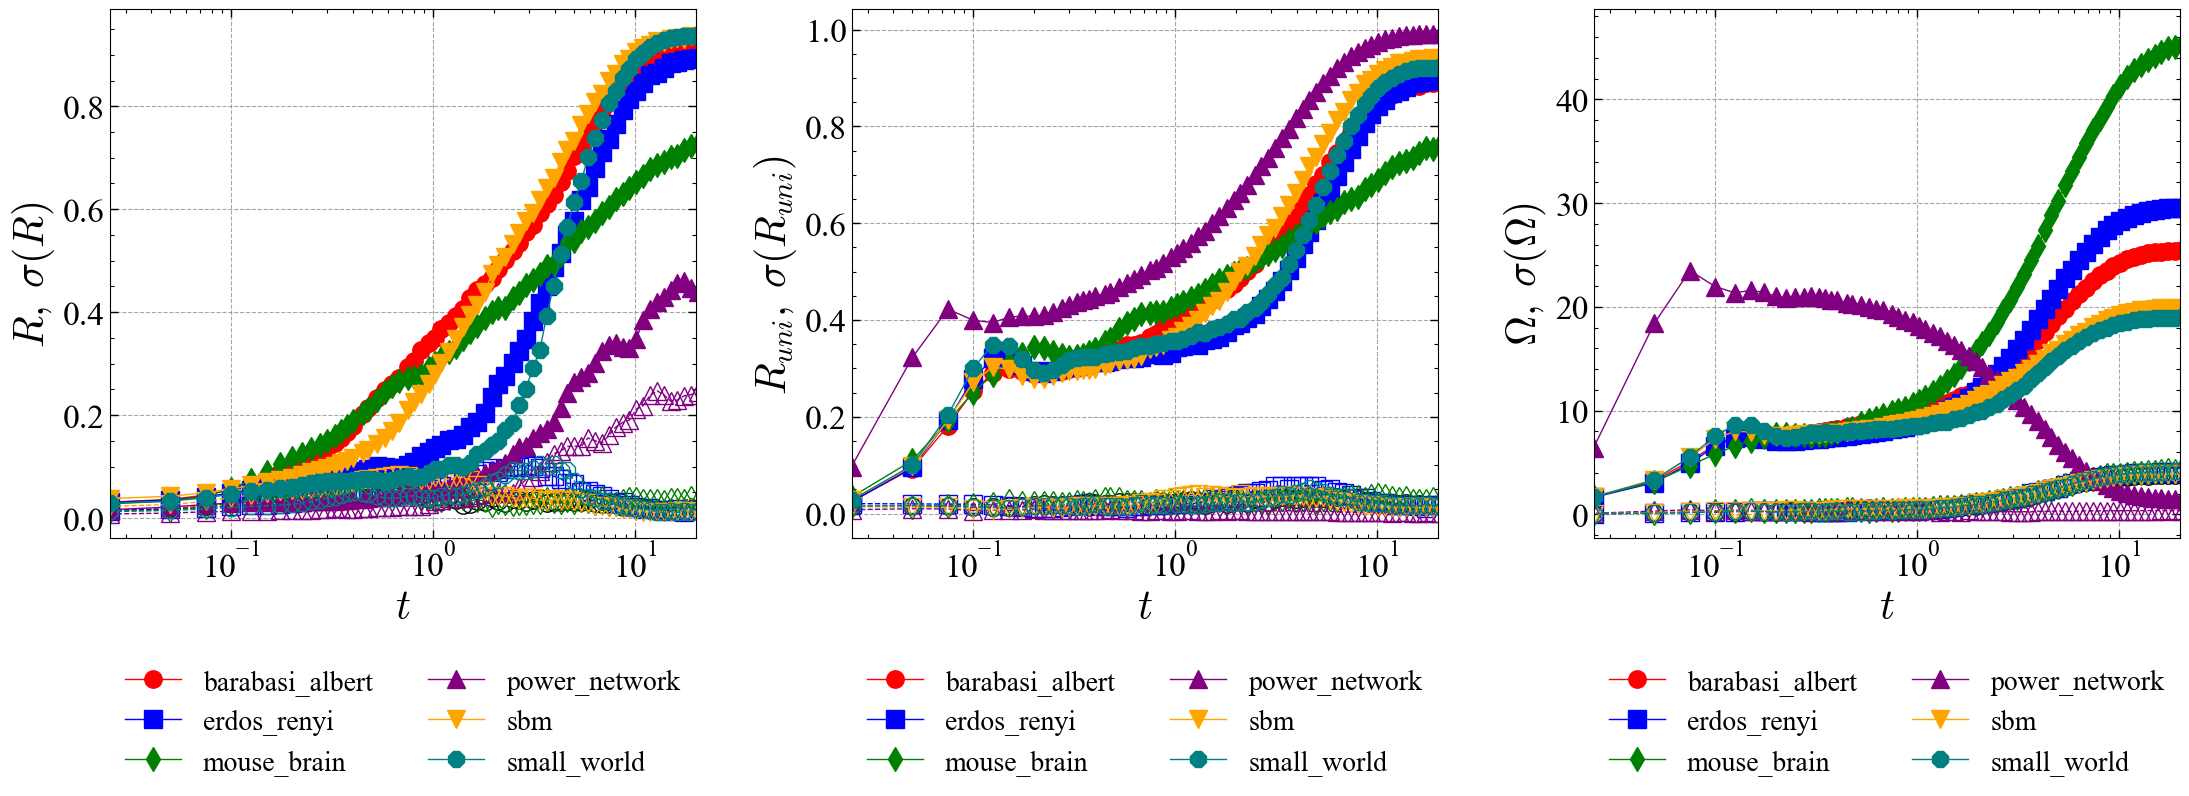

In [86]:
all_graph_styles = {
    'avg_line': {'color': 'red', 'linestyle': '-', 'marker': 'o', 'mfc': 'r', 'mec': 'red'},
    'std_line': {'color': 'black', 'linestyle': '--', 'marker': 'o', 'mfc': 'none', 'mec': 'black'}
}

styles = [
    {
        'avg_line': {'color': 'red', 'linestyle': '-', 'marker': 'o', 'mfc': 'r', 'mec': 'red'},
        'std_line': {'color': 'red', 'linestyle': '--', 'marker': 'o', 'mfc': 'none', 'mec': 'black'}
    },
    {
        'avg_line': {'color': 'blue', 'linestyle': '-', 'marker': 's', 'mfc': 'b', 'mec': 'blue'},
        'std_line': {'color': 'blue', 'linestyle': '--', 'marker': 's', 'mfc': 'none', 'mec': 'blue'}
    },
    {
        'avg_line': {'color': 'green', 'linestyle': '-', 'marker': 'd', 'mfc': 'g', 'mec': 'green'},
        'std_line': {'color': 'green', 'linestyle': '--', 'marker': 'd', 'mfc': 'none', 'mec': 'green'}
    },
    {
        'avg_line': {'color': 'purple', 'linestyle': '-', 'marker': '^', 'mfc': 'purple', 'mec': 'purple'},
        'std_line': {'color': 'purple', 'linestyle': '--', 'marker': '^', 'mfc': 'none', 'mec': 'purple'}
    },
    {
        'avg_line': {'color': 'orange', 'linestyle': '-', 'marker': 'v', 'mfc': 'orange', 'mec': 'orange'},
        'std_line': {'color': 'orange', 'linestyle': '--', 'marker': 'v', 'mfc': 'none', 'mec': 'orange'}
    },
    {
        'avg_line': {'color': 'teal', 'linestyle': '-', 'marker': '8', 'mfc': 'teal', 'mec': 'teal'},
        'std_line': {'color': 'teal', 'linestyle': '--', 'marker': '8', 'mfc': 'none', 'mec': 'teal'}
    }
]

all_graph_metrics = [
    (avg_ord_param, std_order_param, r'$R,\; \sigma(R)$', r'R'),
    (avg_univ_ord_param, std_univ_ord_param, r'$R_{uni},\; \sigma(R_{uni})$', r'$R_{uni}$'),
    (avg_freq_spread, std_freq_spread, r'$\Omega,\; \sigma(\Omega)$', r'\Omega')
]

plot_metrics_all_graphs(convert_to_list_of_lists(avg_metric_result_collector), 
                        styles, 
                        marker_size=12.5,
                        log_scale=[True, False],
                        aspect_ratio=(22.5, 8.5),
                        savename='avg_global_metrics_all_graphs.png')

In [ ]:
all_graph_metrics = [
    (avg_ord_param, std_order_param, r'$R,\; \sigma(R)$', r'R'),
    (avg_univ_ord_param, std_univ_ord_param, r'$R,\; \sigma(R)$', r'R'),
    (avg_freq_spread, std_freq_spread, r'$\Omega,\; \sigma(\Omega)$', r'\Omega')
]

styles = [
    {
        'avg_line': {'color': 'red', 'linestyle': '-', 'marker': 'o', 'mfc': 'none', 'mec': 'red'},
        'std_line': {'color': 'black', 'linestyle': '--', 'marker': 's', 'mfc': 'none', 'mec': 'black'}
    },
    {
        'avg_line': {'color': 'blue', 'linestyle': '-', 'marker': 'd', 'mfc': 'blue', 'mec': 'blue'},
        'std_line': {'color': 'green', 'linestyle': '--', 'marker': '^', 'mfc': 'none', 'mec': 'green'}
    },
    {
        'avg_line': {'color': 'purple', 'linestyle': '-', 'marker': 'x', 'mfc': 'purple', 'mec': 'purple'},
        'std_line': {'color': 'orange', 'linestyle': '--', 'marker': '+', 'mfc': 'none', 'mec': 'orange'}
    }
]

all_graph_styles = {
        'avg_line': {'color': 'red', 'linestyle': '-', 'marker': 'o', 'mfc': 'r', 'mec': 'red'},
        'std_line': {'color': 'black', 'linestyle': '--', 'marker': 'o', 'mfc': 'none', 'mec': 'black'}
    }

all_graph_styles2 = {
        'avg_line': {'color': 'g', 'linestyle': '-', 'marker': 'o', 'mfc': 'r', 'mec': 'red'},
        'std_line': {'color': 'b', 'linestyle': '--', 'marker': 'o', 'mfc': 'none', 'mec': 'black'}
    }

plot_metrics(t, [all_graph_metrics, all_graph_metrics], [all_graph_styles, all_graph_styles2])

In [ ]:
graphs_collector['power_network']

{'erdos_renyi': <igraph.Graph at 0x7de373fda550>,
 'small_world': <igraph.Graph at 0x7de373fda450>,
 'barabasi_albert': <igraph.Graph at 0x7de373fda350>,
 'sbm': <igraph.Graph at 0x7de373fda650>,
 'mouse_brain': <igraph.Graph at 0x7de373fda750>,
 'power_network': <igraph.Graph at 0x7de373fda850>}

In [89]:
graph_names

['barabasi_albert',
 'erdos_renyi',
 'mouse_brain',
 'power_network',
 'sbm',
 'small_world']

In [125]:
# Choose a colormap (e.g., 'viridis')
colormap = plt.cm.magma

# Map values to colors using the colormap
colors = colormap(results[3]['therm']['local_order_param'])

na.plot_graph(graphs_collector['power_network'], 
              savename=f'p_us.png', 
              layout='rt_circular',
              vertex_color=colors.tolist(),
              vertex_size=7.5)

In [53]:
for graph, g_metrics in graph_result_container.items():
    print(graph)
    uniques, counts = np.unique(g_metrics['communities_infomap'], return_counts = 1)
    print(f'Largest community ID: {uniques[np.argmax(counts)]} and size: {max(counts)}')
    print(f'Total number of communities: {len(uniques)} and total number of nodes: {sum(counts)}')
    print("")

    

erdos_renyi
Largest community ID: 85 and size: 19
Total number of communities: 155 and total number of nodes: 1000

small_world
Largest community ID: 125 and size: 13
Total number of communities: 134 and total number of nodes: 1000

barabasi_albert
Largest community ID: 1 and size: 16
Total number of communities: 126 and total number of nodes: 1000

sbm
Largest community ID: 68 and size: 14
Total number of communities: 145 and total number of nodes: 1000

mouse_brain
Largest community ID: 4 and size: 49
Total number of communities: 147 and total number of nodes: 1029

power_network
Largest community ID: 450 and size: 36
Total number of communities: 492 and total number of nodes: 4942



In [32]:
# Initialize a defaultdict where each new key starts with an empty list
avg_metric_result_collector_with_comms = defaultdict(list)

directories, graph_names = get_relative_subdirectories('NetworkingWithKuraPy/output/')
avg_metric_result_collector_with_comms['graphs'] = graph_names

save_res = True

for i, directory in enumerate(tqdm(directories)):
    results = io.load_data_from_directory(directory, 
                                        f".pkl.gz",
                                        compress=True)
    avg_ord_param, avg_univ_ord_param, avg_freq_spread = [], [], []
    avg_ord_param_comm, avg_univ_ord_param_comm, avg_freq_spread_comm = [], [], []

    for result in results:
        avg_ord_param.append(result['therm']['order_param'])
        avg_univ_ord_param.append(result['therm']['universal_order_param'])
        avg_freq_spread.append(result['therm']['frequency_spread'])

        uniques, counts = np.unique(graph_result_container[graph_names[i]]['communities_infomap'], return_counts = 1)
        largest_community = uniques[np.argmax(counts)]
        avg_metric_result_collector_with_comms['largest_comms'].append(largest_community)
        avg_ord_param_comm.append(result['therm'][f'order_param_comm{largest_community}'])
        avg_univ_ord_param_comm.append(result['therm'][f'universal_order_param_comm{largest_community}'])
        avg_freq_spread_comm.append(result['therm'][f'frequency_spread_comm{largest_community}'])
        
        avg_metric_result_collector_with_comms['times'].append(result['therm']['time'] * 0.1 *0.25)
    
    avg_ord_param, std_order_param = get_avg_std(avg_ord_param)
    avg_metric_result_collector_with_comms['avg_ord_params'].append(avg_ord_param)
    avg_metric_result_collector_with_comms['std_order_params'].append(std_order_param)
    
    avg_univ_ord_param, std_univ_ord_param = get_avg_std(avg_univ_ord_param)
    avg_metric_result_collector_with_comms['avg_univ_ord_params'].append(avg_univ_ord_param)
    avg_metric_result_collector_with_comms['std_univ_ord_params'].append(std_univ_ord_param)
    
    avg_freq_spread, std_freq_spread = get_avg_std(avg_freq_spread)
    avg_metric_result_collector_with_comms['avg_freq_spreads'].append(avg_freq_spread)
    avg_metric_result_collector_with_comms['std_freq_spreads'].append(std_freq_spread)
    
    avg_ord_param, std_order_param = get_avg_std(avg_ord_param_comm)
    avg_metric_result_collector_with_comms['avg_ord_params_comms'].append(avg_ord_param)
    avg_metric_result_collector_with_comms['std_order_params_comms'].append(std_order_param)
    
    avg_univ_ord_param, std_univ_ord_param = get_avg_std(avg_univ_ord_param_comm)
    avg_metric_result_collector_with_comms['avg_univ_ord_params_comms'].append(avg_univ_ord_param)
    avg_metric_result_collector_with_comms['std_univ_ord_params_comms'].append(std_univ_ord_param)
    
    avg_freq_spread, std_freq_spread = get_avg_std(avg_freq_spread_comm)
    avg_metric_result_collector_with_comms['avg_freq_spreads_comms'].append(avg_freq_spread)
    avg_metric_result_collector_with_comms['std_freq_spreads_comms'].append(std_freq_spread)

if save_res:
    io.save_data(avg_metric_result_collector_with_comms, 'avg_with_largest_comms_metrics_all_graphs.pkl')

100%|██████████| 6/6 [00:31<00:00,  5.19s/it]


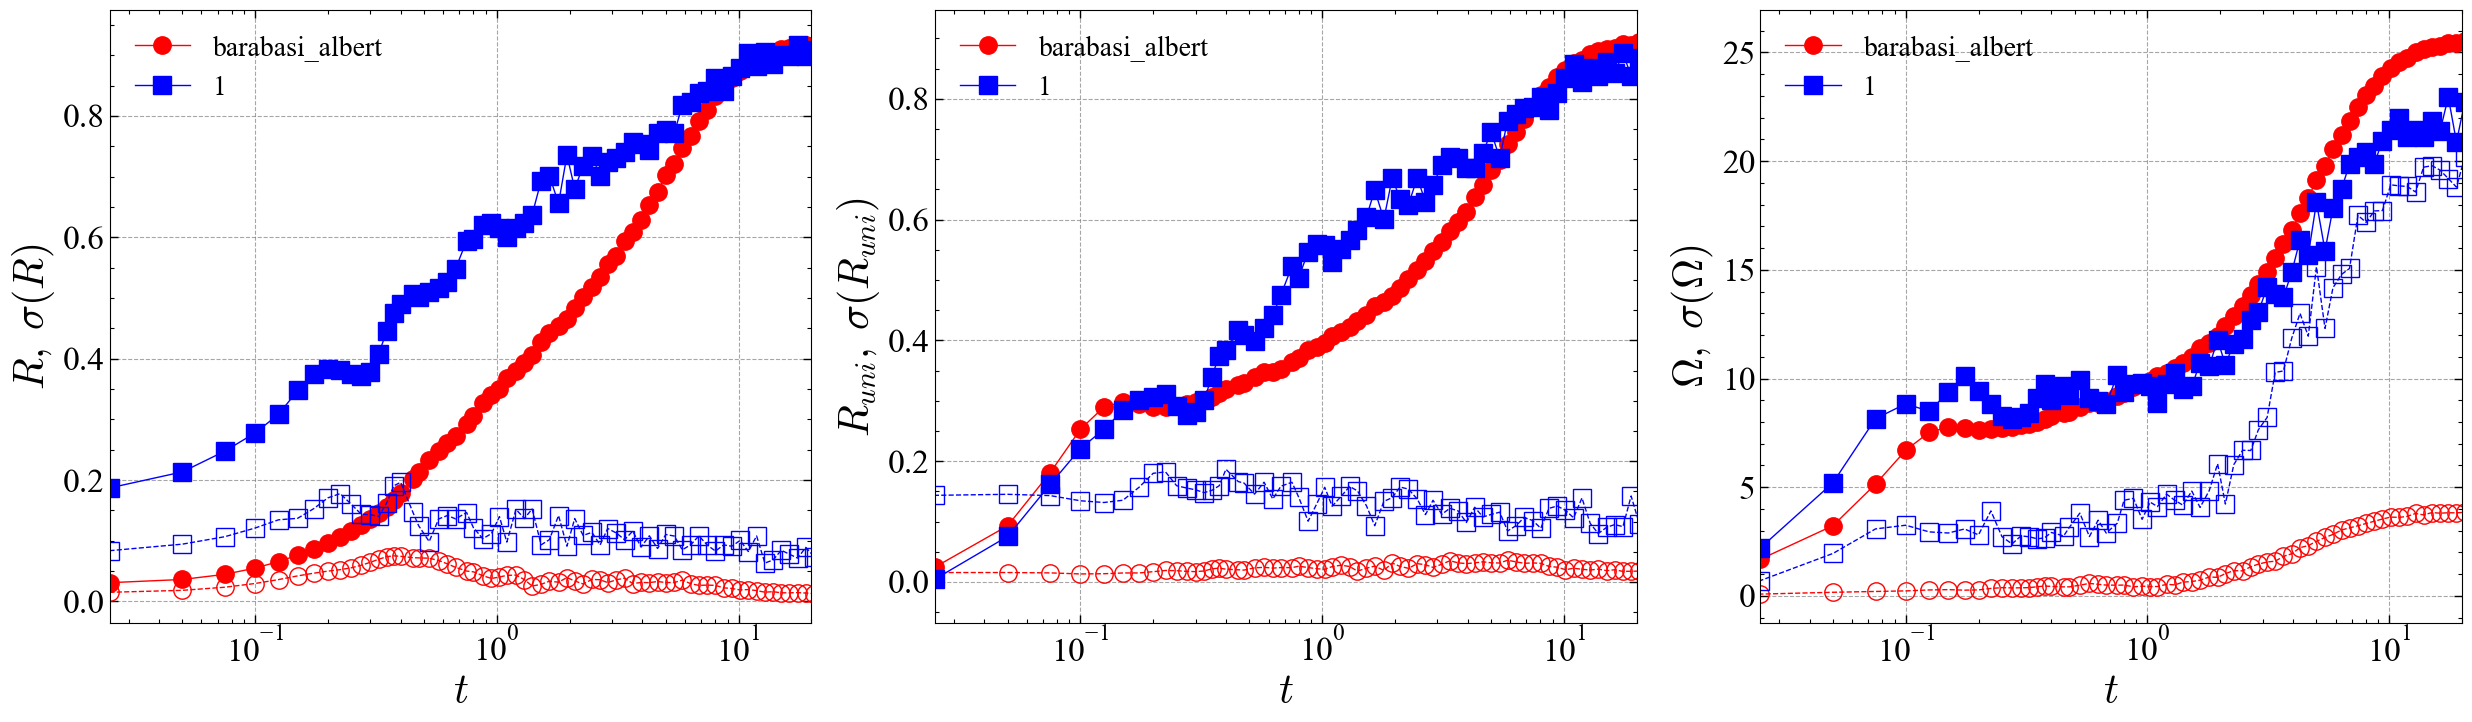

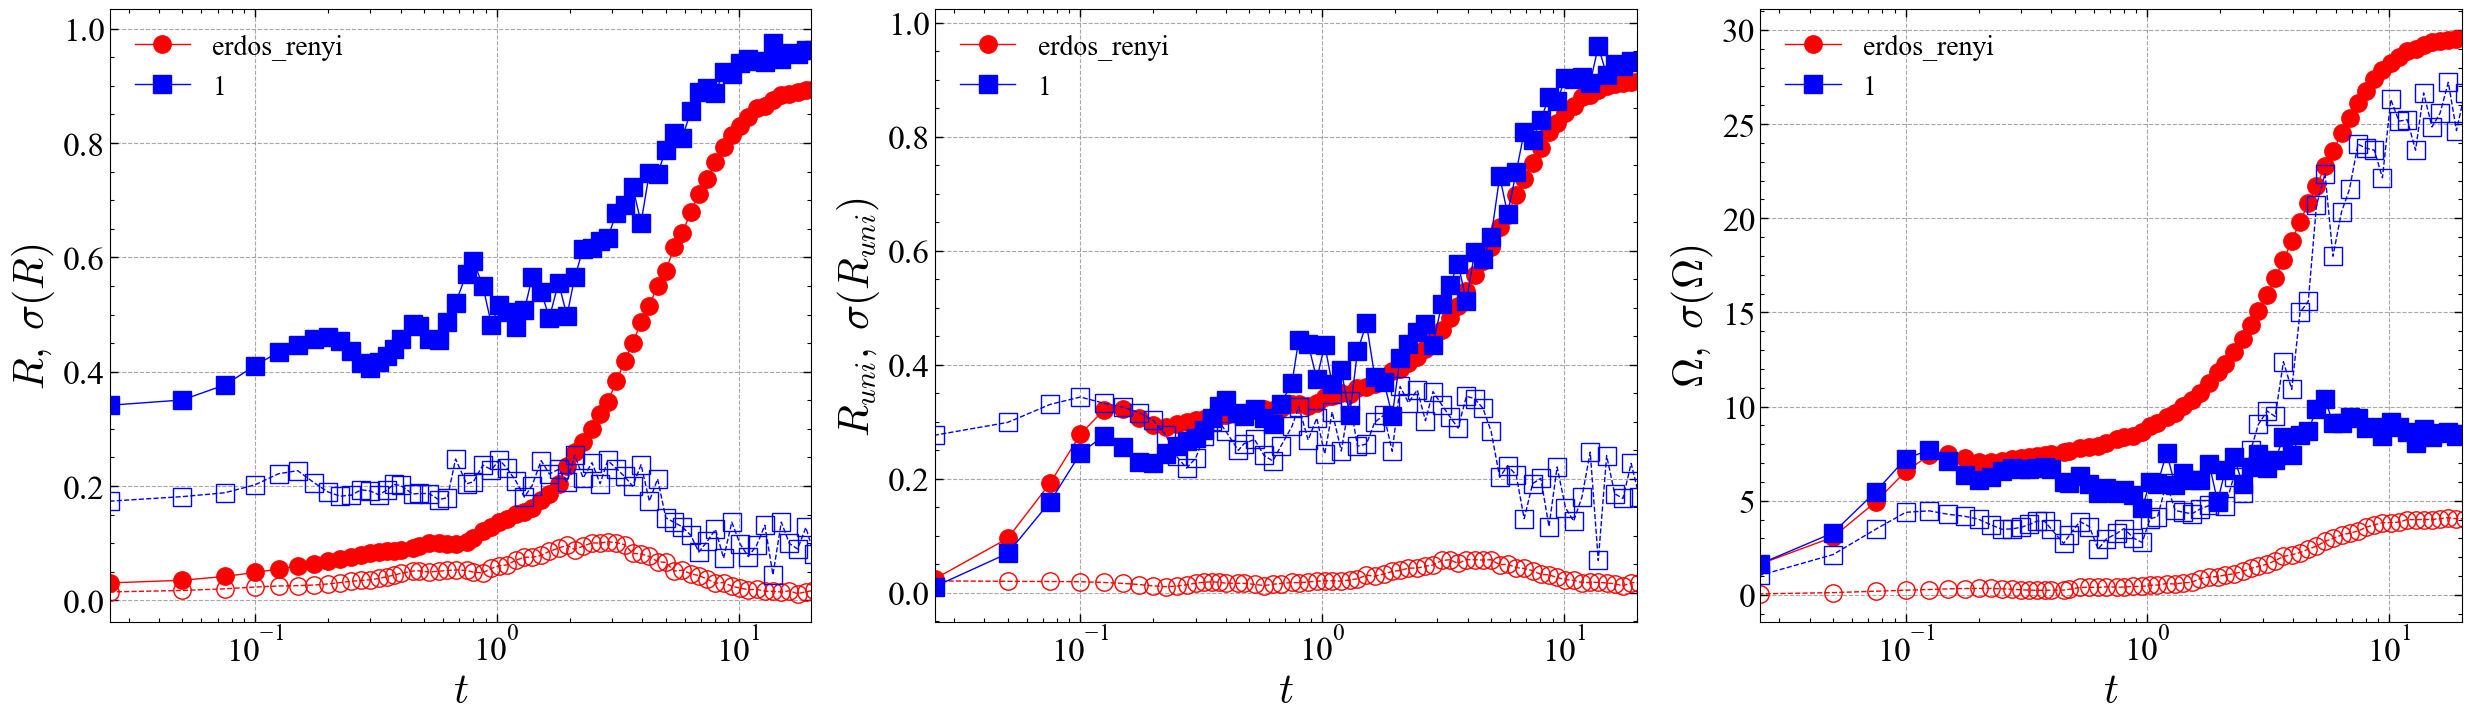

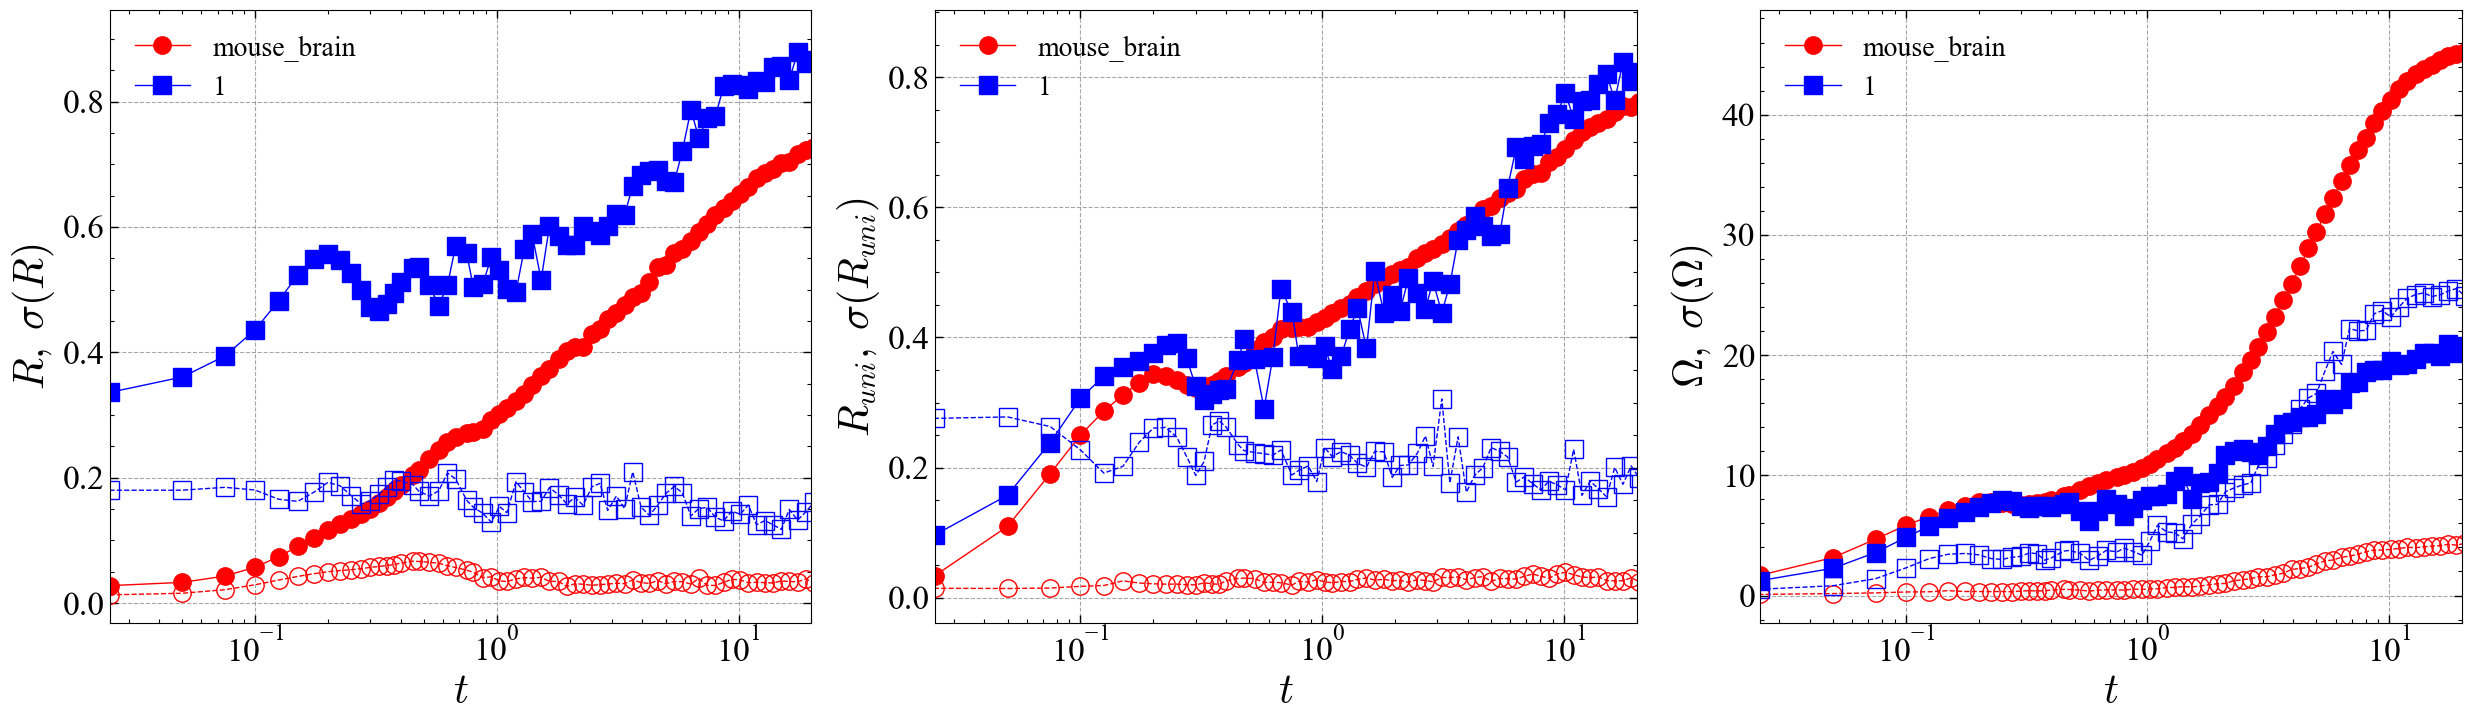

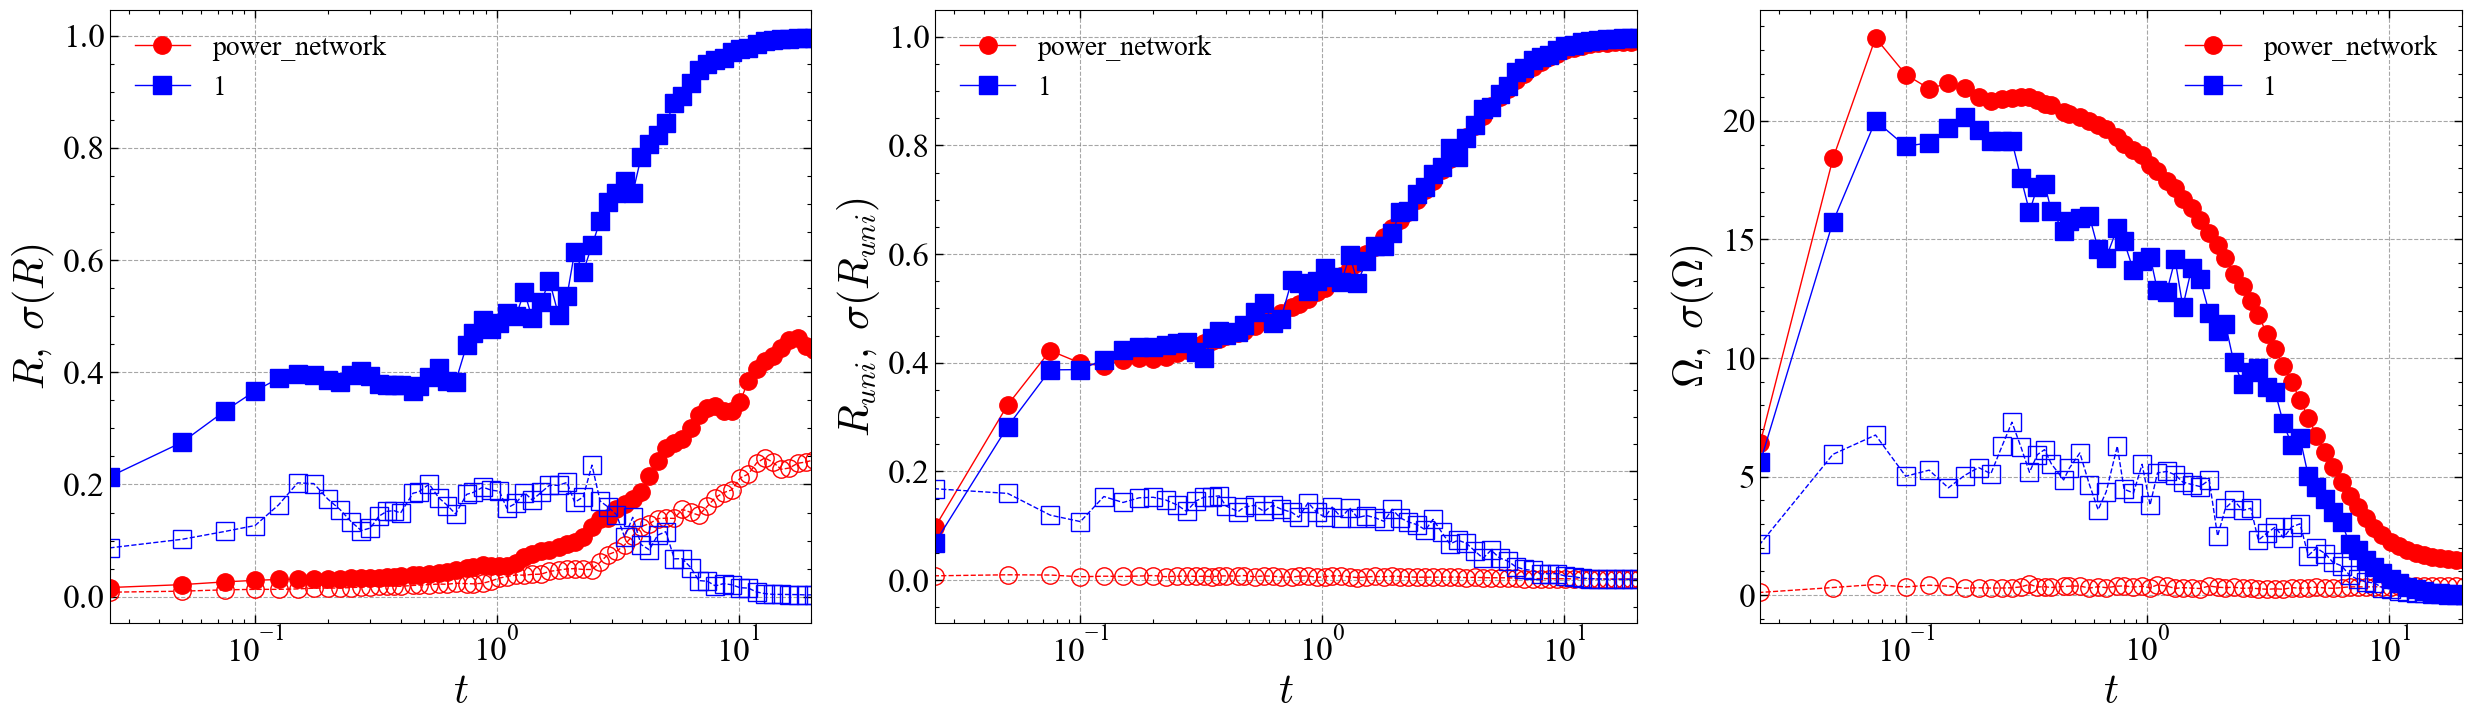

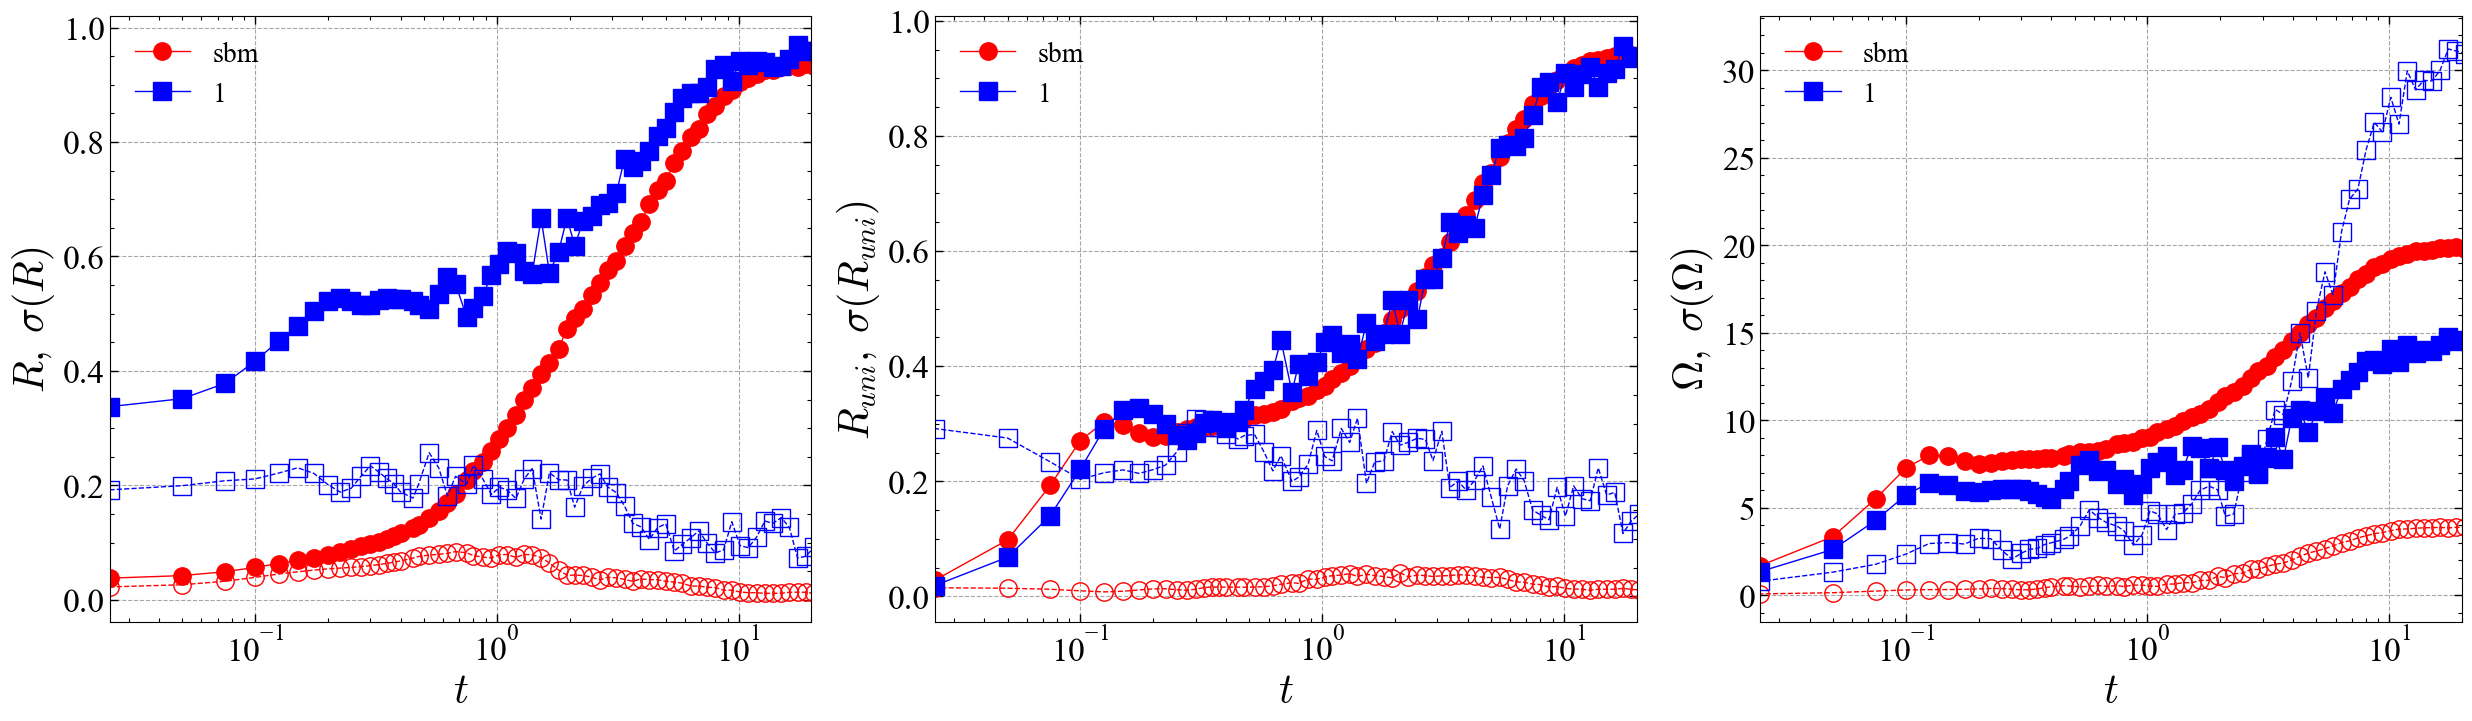

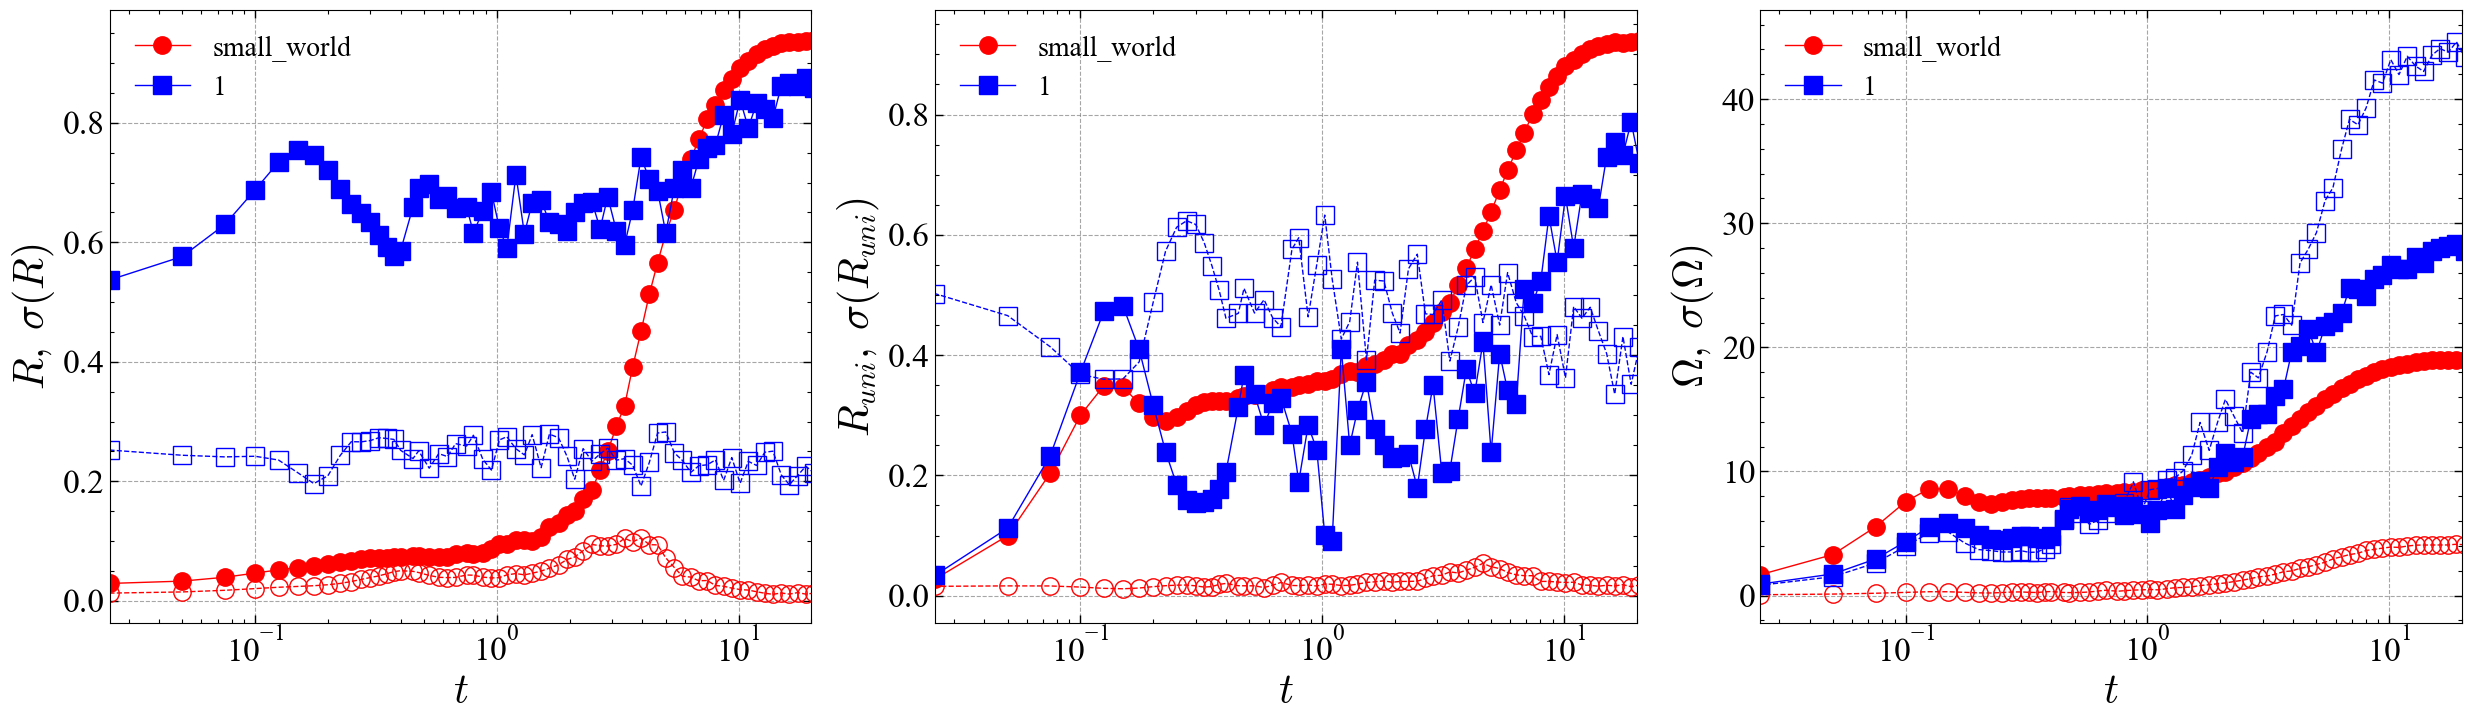

In [49]:
all_graph_styles = [
    {
        'avg_line': {'color': 'red', 'linestyle': '-', 'marker': 'o', 'mfc': 'r', 'mec': 'red'},
        'std_line': {'color': 'red', 'linestyle': '--', 'marker': 'o', 'mfc': 'none', 'mec': 'red'}
    },
    {
        'avg_line': {'color': 'blue', 'linestyle': '-', 'marker': 's', 'mfc': 'b', 'mec': 'blue'},
        'std_line': {'color': 'blue', 'linestyle': '--', 'marker': 's', 'mfc': 'none', 'mec': 'blue'}
    }]

id = 0
for id in range(len(avg_metric_result_collector_with_comms['graphs'])):
    t = avg_metric_result_collector_with_comms['times'][id]
    name = avg_metric_result_collector_with_comms['graphs'][id]
    comm_id = avg_metric_result_collector_with_comms['largest_comms'][id]

    avg_ord_param = avg_metric_result_collector_with_comms['avg_ord_params'][id]
    avg_univ_ord_param = avg_metric_result_collector_with_comms['avg_univ_ord_params'][id]
    avg_freq_spread = avg_metric_result_collector_with_comms['avg_freq_spreads'][id]

    std_order_param = avg_metric_result_collector_with_comms['std_order_params'][id]
    std_univ_ord_param = avg_metric_result_collector_with_comms['std_univ_ord_params'][id]
    std_freq_spread = avg_metric_result_collector_with_comms['std_freq_spreads'][id]

    avg_ord_param_comm = avg_metric_result_collector_with_comms['avg_ord_params_comms'][id]
    avg_univ_ord_param_comm = avg_metric_result_collector_with_comms['avg_univ_ord_params_comms'][id]
    avg_freq_spread_comm = avg_metric_result_collector_with_comms['avg_freq_spreads_comms'][id]

    std_order_param_comm = avg_metric_result_collector_with_comms['std_order_params_comms'][id]
    std_univ_ord_param_comm = avg_metric_result_collector_with_comms['std_univ_ord_params_comms'][id]
    std_freq_spread_comm = avg_metric_result_collector_with_comms['std_freq_spreads_comms'][id]

    all_graph_metrics = [[
        (avg_ord_param, std_order_param, r'$R,\; \sigma(R)$', name),
        (avg_univ_ord_param, std_univ_ord_param, r'$R_{uni},\; \sigma(R_{uni})$', name),
        (avg_freq_spread, std_freq_spread, r'$\Omega,\; \sigma(\Omega)$', name)
    ],[
        (avg_ord_param_comm, std_order_param_comm, r'$R,\; \sigma(R)$', comm_id),
        (avg_univ_ord_param_comm, std_univ_ord_param_comm, r'$R_{uni},\; \sigma(R_{uni})$', comm_id),
        (avg_freq_spread_comm, std_freq_spread_comm, r'$\Omega,\; \sigma(\Omega)$', comm_id)
    ]]

    plot_metrics(t, all_graph_metrics, all_graph_styles, 
                 log_scale=[True, False], aspect_ratio=(25., 7.5),
                 savename=f'imgs/all_graph_plots/comparison_comm_vs_global/avg_global_metrics_vs_largest_comm_{name}.png')

## Resources

All real world (not generated) graphs come from external sources. The road networks were downloaded from/with [2] and the other networks were downloaded from [1].

## Code availability

The project source code is hosted at my [GitHub](https://github.com/)


1. Rossi, R. A., & Ahmed, N. K. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. Proceedings of the AAAI Conference on Artificial Intelligence. Retrieved from https://networkrepository.com
2. Boeing, (2017), OSMnx: A Python package to work with graph-theoretic OpenStreetMap street networks, Journal of Open Source Software, 2(12), 215, doi:10.21105/joss.00215
3. Acebrón, J. A., Bonilla, L. L., Pérez Vicente, C. J., Ritort, F., & Spigler, R. (2005). The Kuramoto model: A simple paradigm for synchronization phenomena. Review of Modern Physics, 77(1), 137–185. https://doi.org/10.1103/RevModPhys.77.137
4. Schröder, M., Timme, M., & Witthaut, D. (2017). A universal order parameter for synchrony in networks of limit cycle oscillators. Chaos: An Interdisciplinary Journal of Nonlinear Science, 27(7). https://doi.org/10.1063/1.4995963
5. [Wikipedia - Kuramoto model](https://en.wikipedia.org/wiki/Kuramoto_model) 